## Problem set 4
## a)

Non-linear least squares fit with:
\begin{equation*}
d = \frac{p_0}{1+(t-p_1)^2/p_2^2},
\end{equation*}
to the data in 'sidebands.npz'.


Best fit parameters are p0= 1.49970971375992 p1= 0.0001923884730818978 p2= 1.6967411973999137e-05


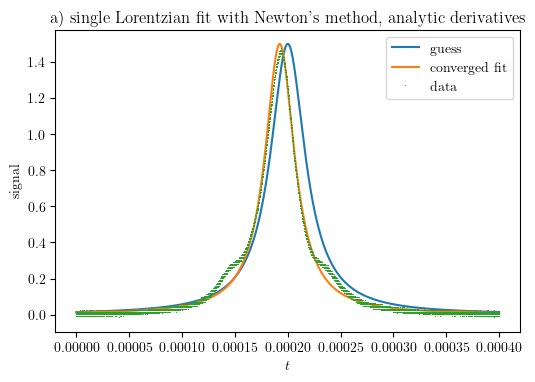

Chi squared is: 83.35079349378628


In [47]:
# pset 4
# a)

import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['figure.dpi'] = 100

data = np.load('sidebands.npz')
t = data['time']
d = data['signal']


# let's try to fit a Lorentzian # f(t) = p0/(1+(t-p1)**2/p2**2)
def lorentz(p,t):
    f = p[0]/(1+(t-p[1])**2/(p[2]**2))
    # analytic derivative for all parameters
    grad = np.zeros([t.size, p.size])
    grad[:,0]=1/(t+(t-p[1])**2/(p[2]**2))
    grad[:,1]=(2*p[0]*p[2]**2*(t-p[1]))/((t-p[1])**2+p[2]**2)**2
    grad[:,2]=(2*p[0]*p[2]*(t-p[1])**2)/((t-p[1])**2+p[2]**2)**2
    return f, grad

# initial (somewhat good) guess for parameters
p_0 = np.array([1.5,0.0002,0.00002])
d0,grad = lorentz(p_0,t)
r=d-d0
err=(r**2).sum()
plt.plot(t,d0,label='guess')

# Newton's method
p=p_0.copy()
print()
for j in range(10):
    pred,grad=lorentz(p,t)
    r=d-pred
    err=(r**2).sum()
    r=np.matrix(r).transpose()
    grad=np.matrix(grad)

    lhs=grad.transpose()*grad
    rhs=grad.transpose()*r
    dp=np.linalg.inv(lhs)*(rhs)
    for jj in range(p.size):
        p[jj]=p[jj]+dp[jj]

print('Best fit parameters are p0=',p[0],'p1=',p[1],'p2=',p[2])  
plt.plot(t,pred,label='converged fit')
plt.plot(t,d,',', label='data')
plt.title("a) single Lorentzian fit with Newton's method, analytic derivatives")
plt.xlabel('$t$')
plt.ylabel('signal')
plt.legend()
plt.show()
chisq = float(r.T@r)
print('Chi squared is:',chisq)

We see that Newton's method converged pretty fast, and the error on the fit is about 83. This does not look too good, maybe a single Lorentzian isn't a super good fit.

In [48]:
# b)
# let's estimate the noise
N = np.mean((d-pred)**2)
Ninv = 1/N
# estimate the error on the parameters
param_err = np.sqrt(np.diag(np.linalg.inv(Ninv*grad.T@grad)))
print('The estimated error on p0 is:', param_err[0])
print('The estimated error on p1 is:', param_err[1])
print('The estimated error on p2 is:', param_err[2])



The estimated error on p0 is: 5.777752590757488e-07
The estimated error on p1 is: 5.658913672030915e-09
The estimated error on p2 is: 5.66476921780537e-09



Best fit parameters are p0= 1.42489199227393 p1= 0.00019238830338205699 p2= 1.787063838973881e-05


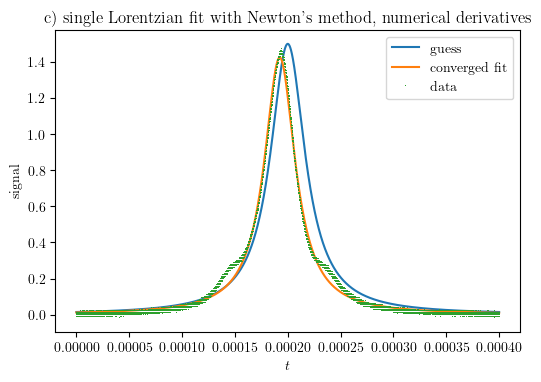

Chi squared is: 63.72012191734764


In [3]:
# c)
# using numerical derivatives

# new lorentz function to make it easier to calculate numerical derivatives 
def lorentz2(p0,p1,p2,t):
    f = p0/(1+(t-p1)**2/(p2**2))
    return f

# two points centered derivative w.r.t. all parameters
# there are 3 parameters so i'll do each derivative separately
def derivative(function,dx0,dx1,dx2):
    dp0 = (function(p0+dx0,p1,p2,t) - function(p0-dx0,p1,p2,t))/(2*dx0)
    dp1 = (function(p0,p1+dx1,p2,t) - function(p0,p1-dx1,p2,t))/(2*dx1)
    dp2 = (function(p0,p1,p2+dx2,t) - function(p0,p1,p2-dx2,t))/(2*dx2)
   
    return dp0,dp1,dp2

# third derivative with respect to all parameters for optimal dx estimate
def third_derivative(function,dx):
    d3p0 = (-0.5*function(p0-2*dx,p1,p2,t) + function(p0-dx,p1,p2,t) - function(p0+dx,p1,p2,t) + 0.5*function(p0+2*dx,p1,p2,t))/(dx**3)
    d3p1 = (-0.5*function(p0,p1-2*dx,p2,t) + function(p0,p1-dx,p2,t) - function(p0,p1+dx,p2,t) + 0.5*function(p0,p1+2*dx,p2,t))/(dx**3)
    d3p2 = (-0.5*function(p0,p1,p2-2*dx,t) + function(p0,p1,p2-dx,t) - function(p0,p1,p2+dx,t) + 0.5*function(p0,p1,p2+2*dx,t))/(dx**3)
    return d3p0,d3p1,d3p2

# estimation of optimal dx, from assignment 1
def optimal_dx(function,dx_0):
    third_deriv = third_derivative(function,dx_0)
    
    with np.errstate(divide = 'ignore'):
        dx_1 = np.cbrt((3*function(p0,p1,p2,t)*1e-16)/third_deriv)
    dx_1[np.where(np.isnan(dx_1))] = dx_0
    dx_1[np.where(np.isinf(dx_1))] = dx_0
    
    return np.abs(dx_1)

# numerical derivative using our optimal dx
def numerical_derivative(function):
    # initial guess of dx is 1e-3
    dx = optimal_dx(function, 1e-3)
    # calculating the derivative
    df = derivative(function, dx[0], dx[1], dx[2])
    return df

def lorentz_numerical(p,t):
    f = p[0]/(1+(t-p[1])**2/(p[2]**2))
    gradn = numerical_derivative(lorentz2)
    grad = np.zeros([t.size,p.size])
    grad[:,0]=gradn[0]
    grad[:,1]=gradn[1]
    grad[:,2]=gradn[2]
    return f, grad

# initial (somewhat good) guess for parameters
p_0 = np.array([1.5,0.0002,0.00002])
p0,p1,p2 = p
d0,grad = lorentz_numerical(p_0,t)
r=d-d0
err=(r**2).sum()

plt.plot(t,d0,label='guess')

# Newton's method
p=p_0.copy()
print()
for j in range(10):
    pred,grad=lorentz_numerical(p,t)
    r=d-pred
    err=(r**2).sum()
    r=np.matrix(r).transpose()
    grad=np.matrix(grad)

    lhs=grad.transpose()*grad
    rhs=grad.transpose()*r
    dp=np.linalg.inv(lhs)*(rhs)
    for jj in range(p.size):
        p[jj]=p[jj]+dp[jj]
    
print('Best fit parameters are p0=',p[0],'p1=',p[1],'p2=',p[2])  
plt.plot(t,pred,label='converged fit')
plt.plot(t,d,',',label='data')
plt.title("c) single Lorentzian fit with Newton's method, numerical derivatives")
plt.xlabel('$t$')
plt.ylabel('signal')
plt.legend()
plt.show()
chisq = float(r.T@r)
print('Chi squared is:',chisq)

Somehow, it seems like the fit is slightly better using numerical derivatives: error on fit is 63 instead of 83. I took the time to get some very good numerical derivatives (two points centered derivative with an estimate of the optimal dx) so the numerical derivatives probably arent very far from the actual, analytical derivatives.

Fit parameters from fit with analytical derivatives: p0= 1.49970971375992 p1= 0.0001923884730818978 p2= 1.6967411973999137e-05.

Fit parameters from fit with numerical derivatives: p0= 1.42489199227393 p1= 0.00019238830338205699 p2= 1.787063838973881e-05

Looks pretty similar, the difference comes from the fact that the value of the numerical derivatives are slightly different from the analytical derivatives, I don't believe the answers are statistically different. However, I don't really understand why the fit is "better" with the numerical derivatives, since they are an "approximation" of the actual, analytical derivative.


## d)
Now fit with the sum of three lorentzians:
\begin{equation*}
d = \frac{p_0}{1+(t-p_1)^2/p_2^2} + \frac{p_3}{1+(t-p_4)^2/p_2^2}+ \frac{p_5}{1+(t-p_4)^2/p_2^2},
\end{equation*}
using numerical derivatives again.


Best fit parameters are p0= 1.4568644925920993 p1= 0.00019255256672578893 p2= 1.547097327186121e-05 p3= 0.12075626780274257 p4= 4.192938627107655e-05 p5= 0.08245464625686161


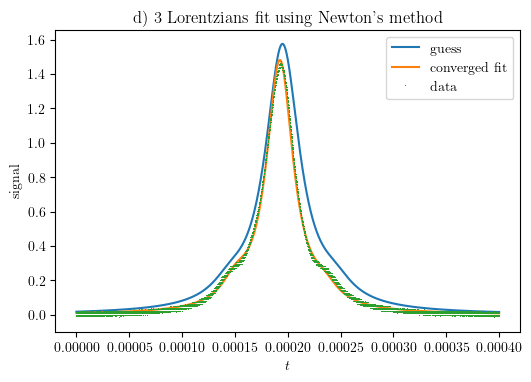

Chi squared is: 24.476991911480905


In [34]:
# d)

# sum of 3 lorentzians
def lorentz_sum(p0,p1,p2,p3,p4,p5,t):
    f = p0/(1+(t-p1)**2/(p2**2))+p3/(1+(t-p1+p4)**2/(p2**2))+p5/(1+(t-p1-p4)**2/(p2**2))
    return f

# for the derivatives, same thing as c) but we now have 6 parameters!!
# two points centered derivative w.r.t. all parameters
def derivative(function,dx0,dx1,dx2,dx3,dx4,dx5):
    dp0 = (function(p0+dx0,p1,p2,p3,p4,p5,t) - function(p0-dx0,p1,p2,p3,p4,p5,t))/(2*dx0)
    dp1 = (function(p0,p1+dx1,p2,p3,p4,p5,t) - function(p0,p1-dx1,p2,p3,p4,p5,t))/(2*dx1)
    dp2 = (function(p0,p1,p2+dx2,p3,p4,p5,t) - function(p0,p1,p2-dx2,p3,p4,p5,t))/(2*dx2)
    dp3 = (function(p0,p1,p2,p3+dx3,p4,p5,t) - function(p0,p1,p2,p3-dx3,p4,p5,t))/(2*dx3)
    dp4 = (function(p0,p1,p2,p3,p4+dx4,p5,t) - function(p0,p1,p2,p3,p4-dx4,p5,t))/(2*dx4)
    dp5 = (function(p0,p1,p2,p3,p4,p5+dx5,t) - function(p0,p1,p2,p3,p4,p5-dx5,t))/(2*dx5)
    return dp0,dp1,dp2,dp3,dp4,dp5

# third derivative with respect to all parameters for optimal dx estimate
def third_derivative(function,dx):
    d3p0 = (-0.5*function(p0-2*dx,p1,p2,p3,p4,p5,t) + function(p0-dx,p1,p2,p3,p4,p5,t) - function(p0+dx,p1,p2,p3,p4,p5,t) + 0.5*function(p0+2*dx,p1,p2,p3,p4,p5,t))/(dx**3)
    d3p1 = (-0.5*function(p0,p1-2*dx,p2,p3,p4,p5,t) + function(p0,p1-dx,p2,p3,p4,p5,t) - function(p0,p1+dx,p2,p3,p4,p5,t) + 0.5*function(p0,p1+2*dx,p2,p3,p4,p5,t))/(dx**3)
    d3p2 = (-0.5*function(p0,p1,p2-2*dx,p3,p4,p5,t) + function(p0,p1,p2-dx,p3,p4,p5,t) - function(p0,p1,p2+dx,p3,p4,p5,t) + 0.5*function(p0,p1,p2+2*dx,p3,p4,p5,t))/(dx**3)
    d3p3 = (-0.5*function(p0,p1,p2,p3-2*dx,p4,p5,t) + function(p0,p1,p2,p3-dx,p4,p5,t) - function(p0,p1,p2,p3+dx,p4,p5,t) + 0.5*function(p0,p1,p2,p3+2*dx,p4,p5,t))/(dx**3)
    d3p4 = (-0.5*function(p0,p1,p2,p3,p4-2*dx,p5,t) + function(p0,p1,p2,p3,p4-dx,p5,t) - function(p0,p1,p2,p3,p4+dx,p5,t) + 0.5*function(p0,p1,p2,p3,p4+2*dx,p5,t))/(dx**3)
    d3p5 = (-0.5*function(p0,p1,p2,p3,p4,p5-2*dx,t) + function(p0,p1,p2,p3,p4,p5-dx,t) - function(p0,p1,p2,p3,p4,p5+dx,t) + 0.5*function(p0,p1,p2,p3,p4,p5+2*dx,t))/(dx**3)
    return d3p0,d3p1,d3p2,d3p3,d3p4,d3p5

# estimation of optimal dx, from assignment 1
def optimal_dx(function,dx_0):
    third_deriv = third_derivative(function,dx_0)
    
    with np.errstate(divide = 'ignore'):
        dx_1 = np.cbrt((3*function(p0,p1,p2,p3,p4,p5,t)*1e-16)/third_derivative(function,dx_0))
    dx_1[np.where(np.isnan(dx_1))] = dx_0
    dx_1[np.where(np.isinf(dx_1))] = dx_0
    
    return np.abs(dx_1)

# numerical derivative using our optimal dx
def numerical_derivative(function):
    # initial guess of dx is 1e-3
    dx = optimal_dx(function, 1e-3)
    # calculating the derivative
    df = derivative(function,dx[0],dx[1],dx[2],dx[3],dx[4],dx[5])
    return df

def lorentz_numerical(p,t):
    f = p[0]/(1+(t-p[1])**2/(p[2]**2))+p[3]/(1+(t-p[1]+p[4])**2/(p[2]**2))+p[5]/(1+(t-p[1]-p[4])**2/(p[2]**2))
    gradn = numerical_derivative(lorentz_sum)
    grad = np.zeros([t.size,p.size])
    grad[:,0]=gradn[0]
    grad[:,1]=gradn[1]
    grad[:,2]=gradn[2]
    grad[:,3]=gradn[3]
    grad[:,4]=gradn[4]
    grad[:,5]=gradn[5]
    return f, grad

# initial (somewhat good) guess for parameters
p_0 = np.array([1.55,0.000195,0.00002,0.09,0.00005,0.09])
p0,p1,p2,p3,p4,p5 = p_0
d0,grad = lorentz_numerical(p_0,t)
r=d-d0
err=(r**2).sum()
plt.plot(t,d0,label='guess')
# Newton's method
p=p_0.copy()
print()
for j in range(15):
    pred,grad=lorentz_numerical(p,t)
    r=d-pred
    err=(r**2).sum()
    r=np.matrix(r).transpose()
    grad=np.matrix(grad)

    lhs=grad.transpose()*grad
    rhs=grad.transpose()*r
    dp=np.linalg.inv(lhs)*(rhs)
    for jj in range(p.size):
        p[jj]=p[jj]+dp[jj]
print('Best fit parameters are p0=',p[0],'p1=',p[1],'p2=',p[2],'p3=',p[3],'p4=',p[4],'p5=',p[5])  
plt.plot(t,pred,label='converged fit')
plt.plot(t,d,',', label = 'data')
plt.xlabel('$t$')
plt.title("d) 3 Lorentzians fit using Newton's method")
plt.ylabel('signal')
plt.legend()
plt.show()
chisq = float(r.T@r)
print('Chi squared is:',chisq)

This is much better, $\chi^2$ is 24 instead of 63. Surely there was a cleaner way to code this, but this works.

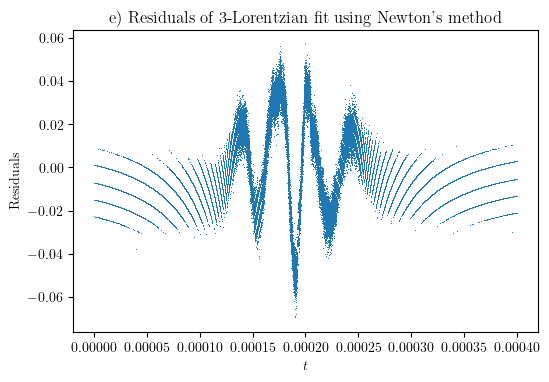

The estimated error on p0 is: 0.00025871080439815274
The estimated error on p1 is: 3.6422413821413994e-09
The estimated error on p2 is: 7.000922036720455e-09
The estimated error on p3 is: 0.00027012056679911496
The estimated error on p4 is: 4.576425575612953e-08
The estimated error on p5 is: 0.00027013530866051556
Noise is: 0.0002447699191148091


In [40]:
# e) 
# residuals are r = d-pred (data minus best fit model)
r = d-pred
plt.plot(t,r,',')
plt.ylabel('Residuals')
plt.xlabel('$t$')
plt.title("e) Residuals of 3-Lorentzian fit using Newton's method")
plt.show()

# let's estimate the noise
N = np.mean((d-pred)**2)
Ninv = 1/N
# estimate the error on the parameters
param_err = np.sqrt(np.diag(np.linalg.inv(Ninv*grad.T@grad)))
print('The estimated error on p0 is:', param_err[0])
print('The estimated error on p1 is:', param_err[1])
print('The estimated error on p2 is:', param_err[2])
print('The estimated error on p3 is:', param_err[3])
print('The estimated error on p4 is:', param_err[4])
print('The estimated error on p5 is:', param_err[5])
print('Noise is:', N)

With residuals like that I can say I am confident the model is absolutely not a complete representation of the data. Seems like the data is not independent and the variance is not uniform, or we have the wrong model.

## f)

Now let's generate some realizations for the parameters error using the covariance matrix $(A^TN^{-1}A)^{-1}$. We can use `np.random.multivariate_normal(mean,cov)` to get a realization of the parameters with error. Here, mean is the best fit parameters of d) and cov is the covariance matrix.

initial chi squared is: 24.476991911480905


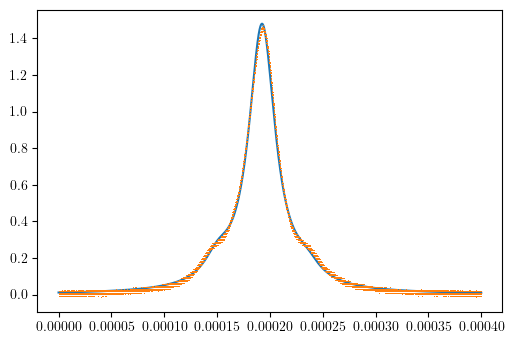

new chi squared is: 24.465665904650454


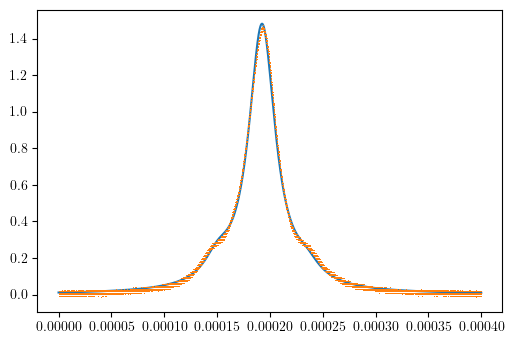

new chi squared is: 24.386800500603318


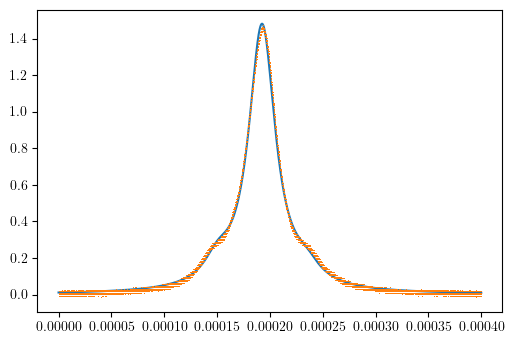

new chi squared is: 24.407051896334366


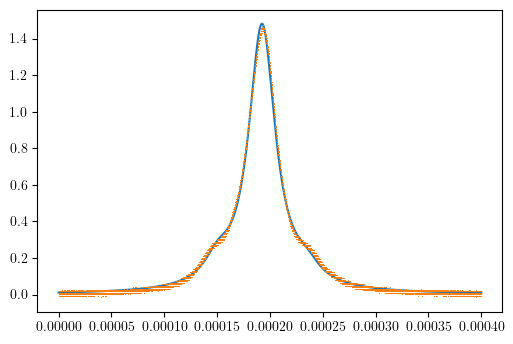

new chi squared is: 24.496472003318054


In [6]:
# f) 
print('initial chi squared is:', chisq)
N = np.mean((d-pred)**2)
Ninv = 1/N
covariance=np.linalg.inv(Ninv*grad.T@grad)
for i in range(4):
    params_with_error=np.random.multivariate_normal(p,covariance)
    plt.plot(t,lorentz_numerical(params_with_error,t)[0])
    plt.plot(t,d,',')
    plt.show()
    r=d-lorentz_numerical(params_with_error,t)[0]
    chisqn=float(r.T@r)
    print('new chi squared is:', chisqn)

$\chi^2$ changes by about 0.05 every time we add the errors using the covariance matrix. This looks fairly reasonable (I have no clue what is or what is not reasonable to be honest, if $\chi^2$ changed by 5 or 10 every time I would say it's big change, but here the change is not even of order unity).

## g)

It's time to use some Markov Chain Monte Carlo to carry out the fit in d). To generate the trial parameters in the chain I will be using the parameters generated by `np.random.multivariate_normal(mean,cov)` where mean is the parameters (start with same initial guess as in d)) and cov is the same covariance matrix as above: $(A^TN^{-1}A)^{-1}$.

C:\Users\Greg\AppData\Local\Temp\ipykernel_3176\949345850.py:29: RuntimeWarning: overflow encountered in exp
  accept_prob=np.exp(-0.5*(chi_trial-chi_cur))


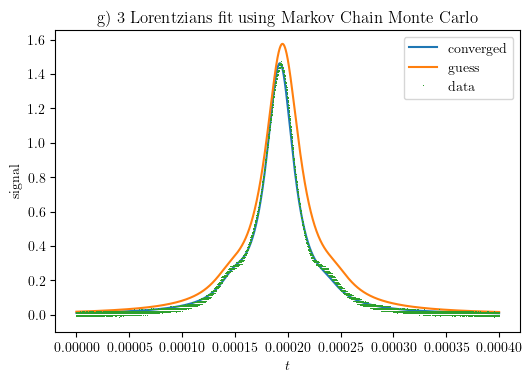

Best fit parameters are: p0= 1.442744348210934 p1= 0.00019257508635802742 p2= 1.6064943477361752e-05 p3= 0.10386722579056376 p4= 4.452328123583935e-05 p5= 0.06529125638067633
Chi squared is: 21.249339711347943


In [36]:
# g)
# fit from d) but using a MCMC

# function we are trying to fit
def lorentz_numerical(p,t):
    f = p[0]/(1+(t-p[1])**2/(p[2]**2))+p[3]/(1+(t-p[1]+p[4])**2/(p[2]**2))+p[5]/(1+(t-p[1]-p[4])**2/(p[2]**2))
    return f

# function to calculate the chi squared during the chain
def chisq(pars):
    model=lorentz_numerical(pars,t)
    chisq=np.sum((d-model)**2/N)
    return chisq

# Markov Chain Monte Carlo
def run_mcmc(pars,data,nstep=5000):
    npar=len(pars)
    chain=np.zeros([nstep,npar])
    chivec=np.zeros(nstep)

    # chi squared at current location
    chi_cur=chisq(pars)
    for i in range(nstep):
        # trial parameters, use realizations of parameters with error from f) as trial step
        pars_trial=np.random.multivariate_normal(pars,covariance)
        # chi squared with trial parameters
        chi_trial=chisq(pars_trial)
        # calculate probability of accepting step
        accept_prob=np.exp(-0.5*(chi_trial-chi_cur))
        if np.random.rand(1)<accept_prob: # accept the step with appropriate probability
            pars=pars_trial
            chi_cur=chi_trial
        chain[i,:]=pars
        chivec[i]=chi_cur
    return chain,chivec

# running the chain with 20000 steps and same initial guess
chain,chivec=run_mcmc(p_0,d,nstep=20000)

plt.plot(t,lorentz_numerical(chain[-1],t), label = 'converged')
plt.plot(t,lorentz_numerical(p_0,t), label = 'guess')
plt.plot(t,d,',', label = 'data')
plt.title("g) 3 Lorentzians fit using Markov Chain Monte Carlo")
plt.xlabel('$t$')
plt.ylabel('signal')
plt.legend()
plt.show()
r = d-lorentz_numerical(chain[-1],t)
print('Best fit parameters are: p0=', chain[-1][0], 'p1=',chain[-1][1],'p2=', chain[-1][2], 'p3=', chain[-1][3], "p4=", chain[-1][4], 'p5=', chain[-1][5])
print('Chi squared is:', float(r.T@r))

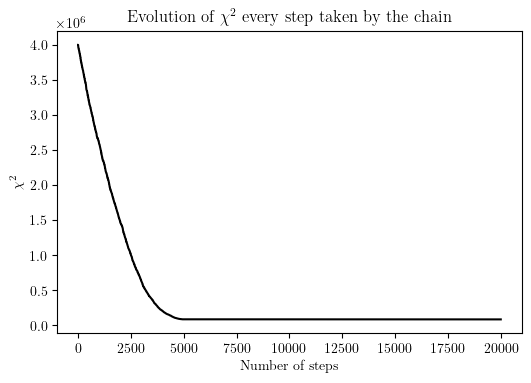

The estimated error on p0 is: 0.0002410506261466484
The estimated error on p1 is: 3.3936138376008528e-09
The estimated error on p2 is: 6.5230234372360605e-09
The estimated error on p3 is: 0.0002516815326421652
The estimated error on p4 is: 4.2640285282299423e-08
The estimated error on p5 is: 0.00025169526819112813
Noise is: 0.0002124933971134795


In [39]:
plt.plot(chivec, 'k-')
plt.ylabel('$\chi^2$')
plt.xlabel('Number of steps')
plt.title('Evolution of $\chi^2$ every step taken by the chain')
plt.show()

noise=np.mean(r**2)
noiseinv = 1/noise
# estimate the error on the parameters
param_errm = np.sqrt(np.diag(np.linalg.inv(noiseinv*grad.T@grad)))
print('The estimated error on p0 is:', param_errm[0])
print('The estimated error on p1 is:', param_errm[1])
print('The estimated error on p2 is:', param_errm[2])
print('The estimated error on p3 is:', param_errm[3])
print('The estimated error on p4 is:', param_errm[4])
print('The estimated error on p5 is:', param_errm[5])
print('Noise is:', noise)

The plot aboves shows the $\chi^2$ at every step of the chain. We can see that it clearly converges to a minimum value after about 5000 steps. The $\chi^2$ after the 20 000 steps of MCMC is smaller than that obtained with Newton's method in d), (21 vs 24), the noise is also smaller (0.000212 vs 0.000245) and the uncertainty on the parameters is also smaller for all parameters obtained using MCMC compared to Newton's method. So yes, I believe the error bar changed: they are smaller now.

## h)

The laser sidebands are offset from the main peak by 9 GHz, however in our model, the separation between them is p4 (dt). We can map p4 to 9GHz and use that to find the width of the cavity, p2 (w), in Ghz.


In [46]:
# convert parameters to hertz
p4_hertz = 1/chain[-1][4]
p2_hertz = 1/chain[-1][2]
# find width in giga hertz 
width = 9*p2_hertz/p4_hertz

print('The width of the cavity resonance in GHz is:',width)


The width of the cavity resonance in GHz is: 24.943102457050184
